In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

In [0]:
#Import GDD and KDD data. Keep only GDD and KDD data
GDD_KDD = pd.read_csv('GDD_KDD_Cleaned.csv', index_col = 0)
GDD_KDD.index = pd.to_datetime(GDD_KDD.index)

GDD_KDD = GDD_KDD.drop(['TMAX_obs', 'TMIN_obs', 'TMAX_bound', 'TMIN_bound'], axis = 1)

In [0]:
#Import development data for Illinois

IL_Development = pd.read_csv('illinois_combined_development_data.csv', index_col = 0)
IL_Development.index = pd.to_datetime(IL_Development.index)

IL_Development = IL_Development.drop(['sum'], axis = 1)

In [0]:
#GDD are calculated for each county and development phase. For each day, multiply percent of crop in phase of interest by the GDD on that day.
#Since we only have one county, product of GDD and percent of crop in phase of interest is the GDD for that day

In [9]:
#Index for both dataframes needs to be identical. Currently they are not because we removed some "bad years" from the weather data due to holes
#Removed 1983, 1986, 1998, 1999, 2000, and 2016. There are 13514 days between (inclusive) 1981 - 2017. Removing these years there should be 11322 days.
#Rember about leap years!

print(len(IL_Development.index))
print(len(GDD_KDD.index))

#Join the dfs. GDD and KDD columns will have NaN for years that were removed in previous cleaning. Then drop rows with any NaN.
df = IL_Development.join(GDD_KDD)
df = df.dropna()

print(len(df.index))

df.head()

13514
11322
11322


,vegetative,early_grain,late_grain,GDD,KDD
1981-01-01,0.0,0.0,0.0,0.0,0.0
1981-01-02,0.0,0.0,0.0,0.0,0.0
1981-01-03,0.0,0.0,0.0,0.0,0.0
1981-01-04,0.0,0.0,0.0,0.0,0.0
1981-01-05,0.0,0.0,0.0,0.0,0.0


In [10]:
#Calculate GDDs and KDDs for phases. Phase data should be in percent format so divide phase columns by 100

phases = ['vegetative', 'early_grain', 'late_grain']

for p in phases:
  df[p] = df[p]/100

for p in phases:
  df['GDD_'+p] = df[p] * df['GDD']
  
for p in phases:
  df['KDD_'+p] = df[p] * df['KDD']
  
df.loc['2017-04-15':'2017-04-20']

,vegetative,early_grain,late_grain,GDD,KDD,GDD_vegetative,GDD_early_grain,GDD_late_grain,KDD_vegetative,KDD_early_grain,KDD_late_grain
2017-04-15,0.051429,0.0,0.0,8.20,0.0,0.421714,0.0,0.0,0.0,0.0,0.0
2017-04-16,0.060000,0.0,0.0,11.00,0.0,0.660000,0.0,0.0,0.0,0.0,0.0
2017-04-17,0.100000,0.0,0.0,6.35,0.0,0.635000,0.0,0.0,0.0,0.0,0.0
2017-04-18,0.140000,0.0,0.0,7.15,0.0,1.001000,0.0,0.0,0.0,0.0,0.0
2017-04-19,0.180000,0.0,0.0,7.70,0.0,1.386000,0.0,0.0,0.0,0.0,0.0
2017-04-20,0.220000,0.0,0.0,8.80,0.0,1.936000,0.0,0.0,0.0,0.0,0.0


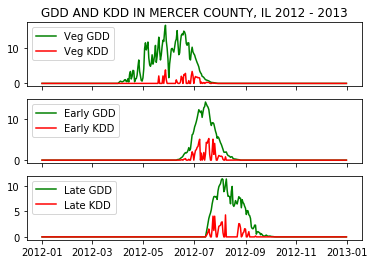

In [12]:
#Visualize GDD and KDD for vegetative phase
#Orientation from https://matplotlib.org/examples/pylab_examples/subplots_demo.html

x = df.loc['2012-01-01':'2012-12-31'].index
y1 = df.loc['2012-01-01':'2012-12-31']['GDD_vegetative'].values
y2 = df.loc['2012-01-01':'2012-12-31']['KDD_vegetative'].values
y3 = df.loc['2012-01-01':'2012-12-31']['GDD_early_grain'].values  
y4 = df.loc['2012-01-01':'2012-12-31']['KDD_early_grain'].values
y5 = df.loc['2012-01-01':'2012-12-31']['GDD_late_grain'].values 
y6 = df.loc['2012-01-01':'2012-12-31']['KDD_late_grain'].values  
  
  
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x, y1, color = 'green', label = 'Veg GDD')
axarr[0].plot(x, y2, color = 'red', label = 'Veg KDD')
axarr[0].legend(loc = 'upper left')
axarr[0].set_title('GDD AND KDD IN MERCER COUNTY, IL 2012 - 2013')

axarr[1].plot(x, y3, color = 'green', label = 'Early GDD')
axarr[1].plot(x, y4, color = 'red', label = 'Early KDD')
axarr[1].legend(loc = 'upper left')

axarr[2].plot(x, y5, color = 'green', label = 'Late GDD')
axarr[2].plot(x, y6, color = 'red', label= 'Late KDD')
axarr[2].legend(loc = 'upper left')

In [14]:
#Find cumulative sum in each phase for each year

#Drop extra rows from df. Only need phase-wise columns.
df1 = df.drop(['vegetative', 'early_grain', 'late_grain', 'GDD', 'KDD'], axis =1) #drop extra columns from df

#Prepare empty df
df_sum = pd.DataFrame()

#Iterate through all years. Filter down to y, find cumulative sum, place values in dataframe. Values in series are in order from df columns.
for y in df1.index.year.unique():
  df_sorted = df1[df1.index.year == y]
  holder = df_sorted.sum(axis = 0)
  df_sum[y] = holder.values

#Swap columns and rows. Fix index and name columns.
df_sum = df_sum.transpose()
df_sum = df_sum.reset_index()
df_sum = df_sum.rename(index = str, columns = {'index':'year', 0:'GDD_vegetative', 1: 'GDD_early_grain', 2:'GDD_late_grain', 3:'KDD_vegetative', 4:'KDD_early_grain', 5:'KDD_late_grain'})
df_sum.tail()

,year,GDD_vegetative,GDD_early_grain,GDD_late_grain,KDD_vegetative,KDD_early_grain,KDD_late_grain
26,2012,701.574000,384.649214,399.781000,46.505571,74.319571,49.877714
27,2013,766.389464,297.524643,504.888381,63.720714,27.951000,76.749762
28,2014,733.184000,301.412643,493.217643,32.315429,6.991143,20.901143
29,2015,767.107500,287.390643,467.498214,16.619000,20.632571,33.914571
30,2017,756.171214,304.800571,496.079786,72.182857,31.967143,12.743000


In [15]:
#Upload the yield data. Filter to Mercer County in IL.
df_yield = pd.read_csv('yield.csv')

df_yield = df_yield[(df_yield['county'] == 'MERCER') & (df_yield['year'] >= 1981) & (df_yield['state_fips'] == 17)]

print(df_yield.head())

print(df_yield.tail())

     year  state_fips  county  county_code  yield
185  2017          17  MERCER          131  238.7
186  2016          17  MERCER          131  213.5
187  2015          17  MERCER          131  205.7
188  2014          17  MERCER          131  193.5
189  2013          17  MERCER          131  177.1
     year  state_fips  county  county_code  yield
217  1985          17  MERCER          131  119.0
218  1984          17  MERCER          131  118.0
219  1983          17  MERCER          131   96.0
220  1982          17  MERCER          131  124.0
221  1981          17  MERCER          131  134.0


In [16]:
#Prepare to combine yield and yearly GDD and KDD data into one dataframe

#Remember that we removed some "bad" years from GDD and KDD data. Remove those same years from yield.
years = df_sum['year'].values
df_yield = df_yield[df_yield['year'].isin(years)]

#Check that the length of years is the same for both dataframes before appending
print(len(df_yield['year']) == len(df_sum['year']))

#Append on years column
mercer_county_df = pd.merge(df_yield, df_sum, how = 'left', on = ['year'])

#Reverse order so oldest is in row 1
#mercer_county_df = mercer_county_df.iloc[::-1]

mercer_county_df.head()

True


,year,state_fips,county,county_code,yield,GDD_vegetative,GDD_early_grain,GDD_late_grain,KDD_vegetative,KDD_early_grain,KDD_late_grain
0,2017,17,MERCER,131,238.7,756.171214,304.800571,496.079786,72.182857,31.967143,12.743000
1,2015,17,MERCER,131,205.7,767.107500,287.390643,467.498214,16.619000,20.632571,33.914571
2,2014,17,MERCER,131,193.5,733.184000,301.412643,493.217643,32.315429,6.991143,20.901143
3,2013,17,MERCER,131,177.1,766.389464,297.524643,504.888381,63.720714,27.951000,76.749762
4,2012,17,MERCER,131,180.1,701.574000,384.649214,399.781000,46.505571,74.319571,49.877714


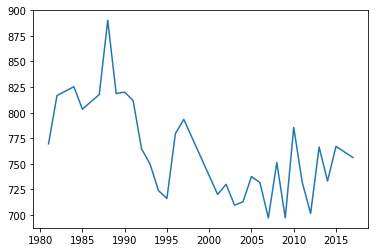

In [17]:
x = mercer_county_df['year']
y = mercer_county_df['GDD_vegetative']
plt.plot(x,y)

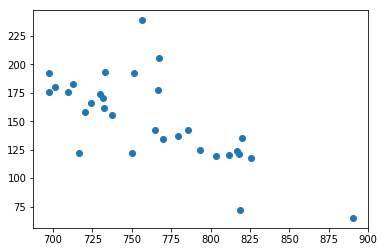

In [18]:
x = mercer_county_df['GDD_vegetative']
y = mercer_county_df['yield']
plt.scatter(x,y)

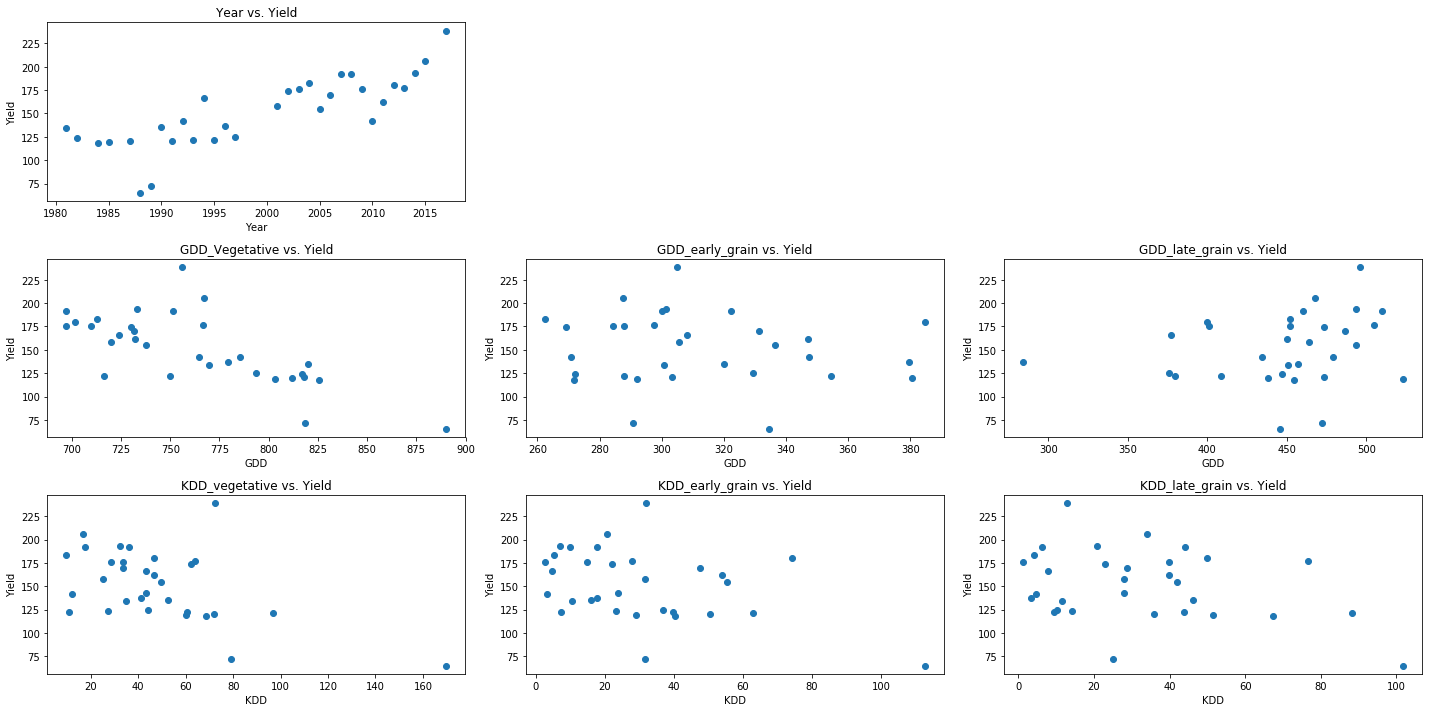

In [19]:
#Check for linearity in variables

df = mercer_county_df
y = df['yield']

f = plt.figure(figsize = (20,10))
ax = f.add_subplot(331)
ax2 = f.add_subplot(334)
ax3 = f.add_subplot(335)
ax4 = f.add_subplot(336)
ax5 = f.add_subplot(337)
ax6 = f.add_subplot(338)
ax7 = f.add_subplot(339)

ax.scatter(df['year'], y)
ax.set_xlabel('Year')
ax.set_ylabel('Yield')
ax.set_title('Year vs. Yield')

ax2.scatter(df['GDD_vegetative'], y)
ax2.set_xlabel('GDD')
ax2.set_ylabel('Yield')
ax2.set_title('GDD_Vegetative vs. Yield')

ax3.scatter(df['GDD_early_grain'], y)
ax3.set_xlabel('GDD')
ax3.set_ylabel('Yield')
ax3.set_title('GDD_early_grain vs. Yield')

ax4.scatter(df['GDD_late_grain'], y)
ax4.set_xlabel('GDD')
ax4.set_ylabel('Yield')
ax4.set_title('GDD_late_grain vs. Yield')

ax5.scatter(df['KDD_vegetative'], y)
ax5.set_xlabel('KDD')
ax5.set_ylabel('Yield')
ax5.set_title('KDD_vegetative vs. Yield')

ax6.scatter(df['KDD_early_grain'], y)
ax6.set_xlabel('KDD')
ax6.set_ylabel('Yield')
ax6.set_title('KDD_early_grain vs. Yield')

ax7.scatter(df['KDD_late_grain'], y)
ax7.set_xlabel('KDD')
ax7.set_ylabel('Yield')
ax7.set_title('KDD_late_grain vs. Yield')

plt.tight_layout()

In [20]:
from sklearn import linear_model

x = mercer_county_df[['year','GDD_vegetative', 'GDD_early_grain', 'GDD_late_grain', 'KDD_vegetative', 'KDD_early_grain', 'KDD_late_grain']]
y =mercer_county_df['yield']

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -4182.942603735888
Coefficients: 
 [ 2.23825635 -0.17328153 -0.09721184  0.07208922 -0.04574813 -0.25745379
 -0.02036167]


In [21]:
mercer_county_df1 = mercer_county_df[['yield','year','GDD_vegetative', 'GDD_early_grain', 'GDD_late_grain', 'KDD_vegetative', 'KDD_early_grain', 'KDD_late_grain']]
mercer_county_df1.corr()

,yield,year,GDD_vegetative,GDD_early_grain,GDD_late_grain,KDD_vegetative,KDD_early_grain,KDD_late_grain
yield,1.000000,0.810016,-0.707427,-0.125314,0.219287,-0.515375,-0.397665,-0.339343
year,0.810016,1.000000,-0.616298,0.150210,0.195404,-0.293747,-0.098699,-0.151420
GDD_vegetative,-0.707427,-0.616298,1.000000,0.010823,0.060306,0.637535,0.422427,0.443050
GDD_early_grain,-0.125314,0.150210,0.010823,1.000000,-0.382408,0.259923,0.507366,0.179020
GDD_late_grain,0.219287,0.195404,0.060306,-0.382408,1.000000,0.110699,0.068556,0.352068
KDD_vegetative,-0.515375,-0.293747,0.637535,0.259923,0.110699,1.000000,0.776412,0.741198
KDD_early_grain,-0.397665,-0.098699,0.422427,0.507366,0.068556,0.776412,1.000000,0.736248
KDD_late_grain,-0.339343,-0.151420,0.443050,0.179020,0.352068,0.741198,0.736248,1.000000


In [0]:
#Make function that calcuates least-squares regression coefficients: https://stattrek.com/multiple-regression/regression-coefficients.aspx
#X and Y will be dataframes containing the independent and dependent variables respectivly

#output = []

def least_squares_coef(X,Y):
  global output
  #Add column of ones to matrix X
  X.insert(0,'ones',1)
  X = X.values

  #Matrix X prime will be the transpose of matrix X
  X_prime = X.transpose()

  #Matrix Y is the dependent variable
  Y = Y.values

  #Calculate regression coefficients
  #b = (X'X)^-1 * X'Y

  W = np.linalg.inv(np.dot(X_prime, X))
  Z = np.dot(X_prime, Y)
  output = np.dot(W,Z)
 

In [0]:
#Apply function to entire dataset
X = mercer_county_df[['year','GDD_vegetative','GDD_early_grain','GDD_late_grain','KDD_vegetative','KDD_early_grain','KDD_late_grain']].copy()
Y = mercer_county_df[['yield']].copy()


least_squares_coef(X,Y)

In [85]:
output

array([[-4.18294260e+03],
       [ 2.23825635e+00],
       [-1.73281526e-01],
       [-9.72118369e-02],
       [ 7.20892191e-02],
       [-4.57481301e-02],
       [-2.57453788e-01],
       [-2.03616650e-02]])

In [24]:
#Compare coefficients with those from sklearn
from sklearn import linear_model

x = mercer_county_df[['year','GDD_vegetative', 'GDD_early_grain', 'GDD_late_grain', 'KDD_vegetative', 'KDD_early_grain', 'KDD_late_grain']]
y = mercer_county_df['yield']

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -4182.942603735888
Coefficients: 
 [ 2.23825635 -0.17328153 -0.09721184  0.07208922 -0.04574813 -0.25745379
 -0.02036167]


In [0]:
#Split data into training and test then calculate coefficients
X = mercer_county_df[['year','GDD_vegetative','GDD_early_grain','GDD_late_grain','KDD_vegetative','KDD_early_grain','KDD_late_grain']].copy()
Y = mercer_county_df[['year','yield']].copy()

#Pick 20 years at random for training, the other 11 will be used for testing
X_train = X.sample(n = 20)

#Need to sort values so row 0 is 2017 so that it matches order in Y matrix
X_train.sort_values(by = ['year'], ascending = False, inplace = True)
X_test = X.loc[~X.index.isin(X_train.index)]

Y_train = Y[Y['year'].isin(X_train['year'].values)]
Y_test = Y.loc[~Y.index.isin(Y_train.index)]
Y_train = Y_train.drop('year', axis = 1)
Y_test = Y_test.drop('year', axis =1)

In [69]:
least_squares_coef(X = X_train, Y = Y_train)

<class 'numpy.ndarray'>


In [66]:
ouput

NameError: ignored

In [0]:
#Make distribution of coefficients

X = mercer_county_df[['year','GDD_vegetative','GDD_early_grain','GDD_late_grain','KDD_vegetative','KDD_early_grain','KDD_late_grain']].copy()
Y = mercer_county_df[['year','yield']].copy()

intercept = []
year_dist = []
GDD_veg = []
GDD_early = []
GDD_late = []
KDD_veg = []
KDD_early = []
KDD_late = []

global output

for i in range(1000):
  X_train = X.sample(n = 20)
  
  #Need to sort values so row 0 is 2017 so that it matches order in Y matrix
  X_train.sort_values(by = ['year'], ascending = False, inplace = True)
  X_test = X.loc[~X.index.isin(X_train.index)]

  Y_train = Y[Y['year'].isin(X_train['year'].values)]
  Y_test = Y.loc[~Y.index.isin(Y_train.index)]
  Y_train = Y_train.drop('year', axis = 1)
  Y_test = Y_test.drop('year', axis =1)
  
  output = []
  least_squares_coef(X = X_train, Y = Y_train)
  
  intercept.append(output[0,0])
  year_dist.append(output[1,0])
  GDD_veg.append(output[2,0])
  GDD_early.append(output[3,0])
  GDD_late.append(output[4,0])
  KDD_veg.append(output[5,0])
  KDD_early.append(output[6,0])
  KDD_late.append(output[7,0])
  

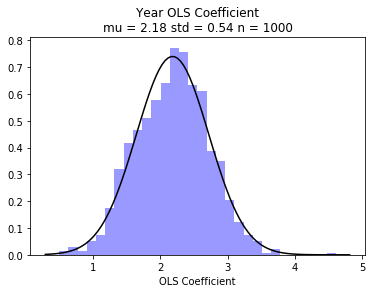

In [128]:
from scipy.stats import norm

plt.hist(year_dist, bins = 30, density = True, alpha = 0.4, color = 'blue')

mu, std = norm.fit(year_dist)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, color = 'black')

plt.xlabel('OLS Coefficient')
plt.title('Year OLS Coefficient\n' + 'mu = ' + str(round(mu,2)) + ' std = ' + str(round(std,2)) + ' n = 1000')
plt.show()

In [0]:
#Function to plot distribution of coefficients and input plots name

def plot_dist(variable):
  name = input("Name of plot? ")
  
  plt.hist(variable, bins = 30, density = True, alpha = 0.4, color = 'blue')

  mu, std = norm.fit(variable)

  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  y = norm.pdf(x, mu, std)
  plt.plot(x, y, color = 'black')

  plt.xlabel(name + ' OLS Coefficient')
  plt.title(name + ' OLS Coefficient\n' + 'mu = ' + str(round(mu,2)) + ' std = ' + str(round(std,2)) + ' n = 1000')
  


Name of plot? KDD_late


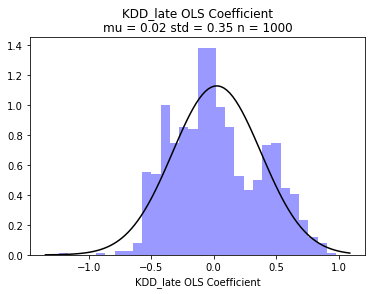

In [165]:
plot_dist(KDD_late)